In [1]:
import warnings
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


%matplotlib inline

warnings.filterwarnings("ignore")

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [3]:
!pip freeze > requirements.txt

In [4]:
# Функция для построения боксплота для выбранных данных
def get_boxplot(column, index, dataframe):
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.boxplot(x=column, y=index,
                data=dataframe,
                ax=ax)
    plt.xticks()
    ax.set_title('Boxplot for ' + index)
    plt.show()
    print()

In [5]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
data_train = pd.read_csv(DATA_DIR+'/train.csv')
data_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')


# Посмотрим на данные в целом

In [6]:
# by Safaroff
# Компактное представление всех данных
d = pd.concat([data_train, data_test], ignore_index=True) # Для представления создаем отдельный df, объединяющий train и test
# число уник значений, выод первых 10 уник значений, кол-во значений null, type
d.agg({'nunique', lambda s: s.unique()[:10]})\
 .append(pd.Series(d.isnull().sum(), name='null'))\
 .append(pd.Series(d.dtypes, name='dtype'))\
 .transpose()

,nunique,<lambda>,null,dtype
client_id,110148,"[25905, 63161, 25887, 16222, 101655, 41415, 28...",0,int64
app_date,120,"[01FEB2014, 12MAR2014, 23JAN2014, 18APR2014, 1...",0,object
education,5,"[SCH, GRD, UGR, PGR, ACD, nan]",478,object
sex,2,"[M, F]",0,object
age,52,"[62, 59, 25, 53, 48, 27, 39, 50, 54, 29]",0,int64
car,2,"[Y, N]",0,object
car_type,2,"[Y, N]",0,object
decline_app_cnt,24,"[0, 2, 1, 3, 4, 6, 5, 7, 8, 9]",0,int64
good_work,2,"[0, 1]",0,int64
score_bki,102618,"[-2.00875292, -1.53227621, -1.40814226, -2.057...",0,float64


In [7]:
data_train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [8]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [9]:
data_test.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [10]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

В обучающем датасете 19 признаков, в тестовом датасете нет переменной "default". Мы должны предсказать ее значение. 

Для корректной обработки признаков объединим датасеты train и test. Переменную "default" в тестовом датасете заполним предварительно нулями. Создадим новую переменную "train", где укажем, какие записи относятся к датасету data_train.

In [11]:
data_test['default'] = 0 # заполняем переменную нулями в тестовом датасете
data_test['train'] = 0 # указываем, что записи не принадлежат датасету train
data_train['train'] = 1 # указываем, что записи принадлежат датасету train
data = data_train.append(data_test, sort=False).reset_index(drop=True) # объединяем датасеты в один

In [12]:
display(data)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,31MAR2014,SCH,F,37,N,N,1,0,-1.744976,3,50,2,3,15000,4,1,N,0,0
110144,106254,25APR2014,GRD,F,64,Y,Y,0,0,-2.293781,3,60,1,2,200000,1,4,N,0,0
110145,81852,30MAR2014,GRD,M,31,N,N,2,0,-0.940752,1,50,1,2,60000,4,2,N,0,0
110146,1971,07JAN2014,UGR,F,27,N,N,1,0,-1.242392,2,80,2,3,30000,1,1,N,0,0


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [14]:
data.isnull().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
train                 0
dtype: int64

Пропуски есть только в столбце "education".

<AxesSubplot:xlabel='default', ylabel='count'>

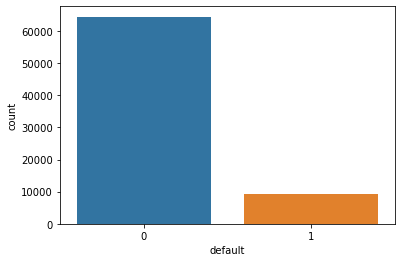

In [15]:
# Посмотрим распределение целевой переменной в тренировочном датасете
sns.countplot(x='default', data=data_train)

Распределение неравномерное, необходимо учитывать это при выборе модели и метрик.

<AxesSubplot:>

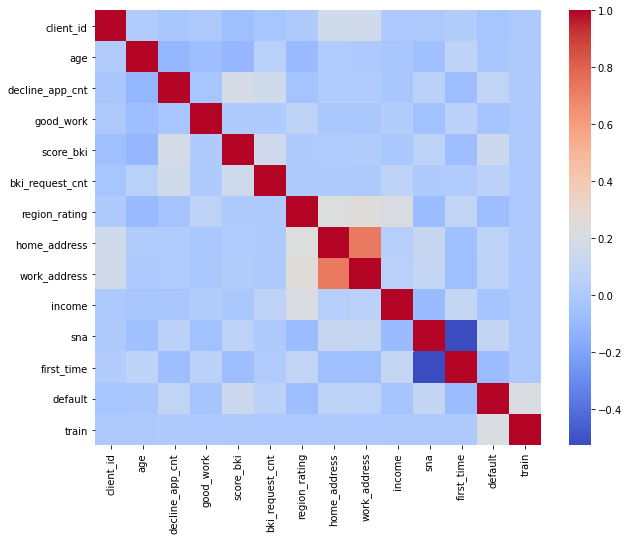

In [16]:
# Посмотрим поверхностно на корреляции признаков
plt.rcParams['figure.figsize'] = (10, 8)
correlation = data.corr()
sns.heatmap(correlation, cmap='coolwarm')

Между домашним и рабочим адресом довольно сильная корреляция, позже сгенерируем из двух признаков один. Довольно сильная отрицательная корреляция между признаками "firts_time" и "sna". Но, так как не очень понятен механизм присвоения категорий по этим признакам, оставим оба признака.

## Обработка пропусков

In [17]:
# Пропуски встречаются только в информации об образовании клиентов. Посмотрим на признак ближе
data.education.value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [18]:
# by Safaroff 
# Предлагаю заполнить пропуск по частоте встречаемости каждого значения
# Проверяю частоту встречиаемости образования, поделив ее на общее число, чтобы выявить пропорцию. 
# Далее домножаю на 10000 для наглядности
sum = data['education'].value_counts().sum()
ed_dict = dict(data['education'].value_counts()/sum*10000)

# Создаю шкалу вероятности, чтобы генерить с помощью RANDINT число (в диапозоне этой шкалы)
# Образование берем из ключа и заполняем пробел в образовании (пока, без фиксации seed)
summ = 0
for key in ed_dict:
    ed_dict[key] += summ
    summ = ed_dict[key]
    
# будем RANDINTом генерить число от 1 до 10000. Куда попадем, то значение и берем
import random

def getter_Education(option=1):
    if option==0: # заполнить пропуск самым частым значенияем
        return data['education'].value_counts().index[0]
    else: # заполнить пропуск по частоте встречаемости каждого значения
        rnd = random.randint(1,10000)
        for key, value in ed_dict.items():
            if rnd > value:
                continue
            else:
                return key

In [19]:
# by Safaroff. 
# data.education.fillna(data.education.value_counts().index[0], inplace=True)
# Заполняем пропуски в образовании c помощью функции с параметром:
# 0-самое часто используемое образование, 1 - в соответсвии с вероятностями исходя из существующего распределения
data['education'].fillna(value=getter_Education(1), inplace=True)

# Exploratory data analysis

In [20]:
# посмотрим количество уникальных значений в каждой переменной датасета
data.nunique()

client_id           110148
app_date               120
education                5
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
default                  2
train                    2
dtype: int64

In [21]:
# Распределим переменные по типу, client_id, default и train не учитываем

time_cols = ['app_date']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time']
num_cols = ['age', 'decline_app_cnt', 'score_bki',
            'bki_request_cnt', 'region_rating', 'income']

## App_date

In [22]:
# Преобразуем формат даты
data.app_date = pd.to_datetime(data.app_date, format='%d%b%Y')

# Определим, за какой период у нас есть наблюдения
start = data.app_date.min()
end = data.app_date.max()
print(start, end)

2014-01-01 00:00:00 2014-04-30 00:00:00


Получили, что у нас есть данные с 1 января по 30 апреля 2014 года.

## Числовые переменные

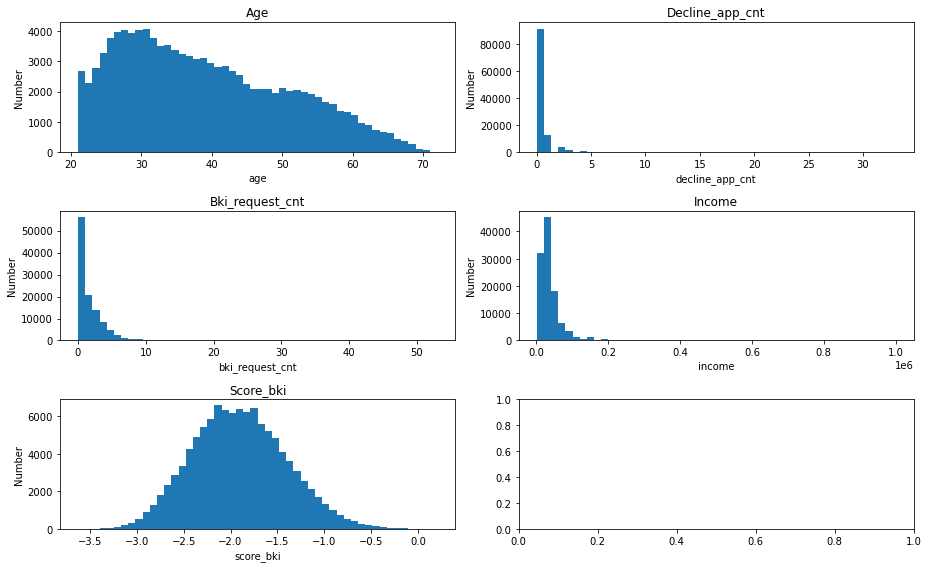

In [23]:
# Посмотрим распределение числовых переменных

fig, axes = plt.subplots(3, 2, figsize=(13, 8))

axes[0][0].hist(data['age'], bins=50)
axes[0][0].set_xlabel('age')
axes[0][0].set_ylabel('Number')
axes[0][0].set_title('Age')

axes[0][1].hist(data['decline_app_cnt'], bins=50)
axes[0][1].set_xlabel('decline_app_cnt')
axes[0][1].set_ylabel('Number')
axes[0][1].set_title('Decline_app_cnt')

axes[1][0].hist(data['bki_request_cnt'], bins=50)
axes[1][0].set_xlabel('bki_request_cnt')
axes[1][0].set_ylabel('Number')
axes[1][0].set_title('Bki_request_cnt')

axes[1][1].hist(data['income'], bins=50)
axes[1][1].set_xlabel('income')
axes[1][1].set_ylabel('Number')
axes[1][1].set_title('Income')

axes[2][0].hist(data['score_bki'], bins=50)
axes[2][0].set_xlabel('score_bki')
axes[2][0].set_ylabel('Number')
axes[2][0].set_title('Score_bki')

"""
axes[2][1].hist(data['region_rating'], bins=50)
axes[2][1].set_xlabel('region_rating')
axes[2][1].set_ylabel('Number')
axes[2][1].set_title('Region_rating') 
"""

fig.tight_layout()

После построения гистограмм стало очевидно, что распределения всех числовых переменных age, decline_app_cnt, decline_app_cnt, income имеют тяжёлый правый хвост. Логарифмируем переменные и построим графики распределения. Score_bki оставим, как есть

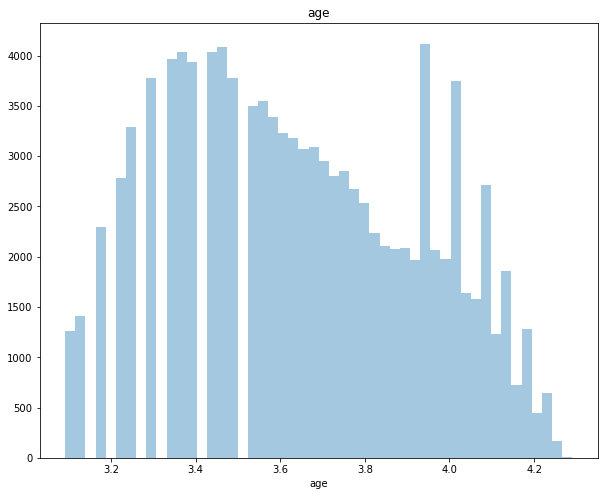

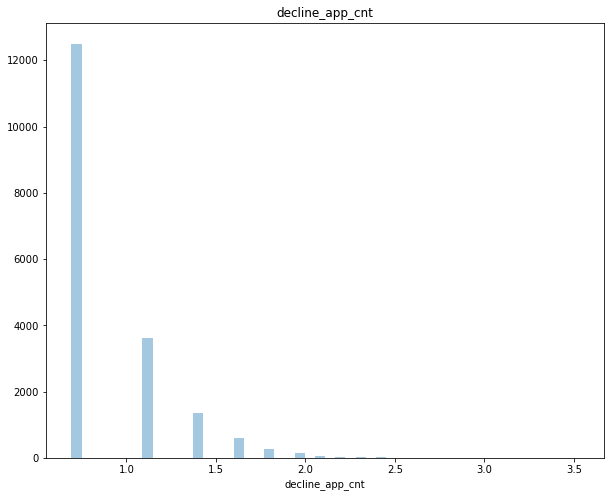

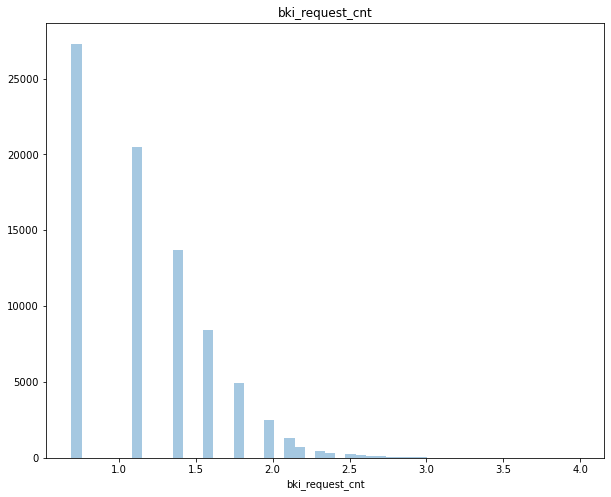

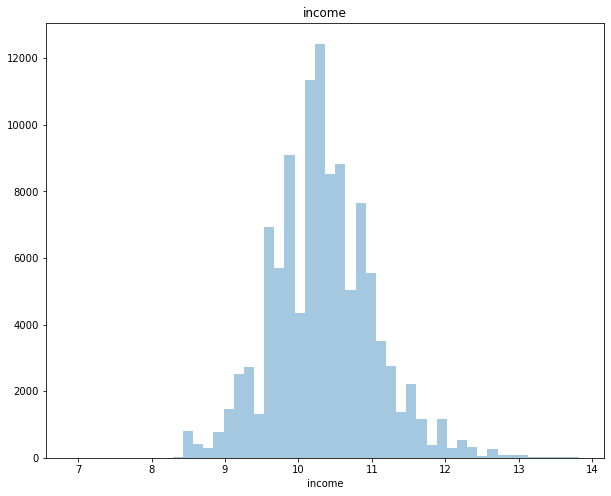

In [24]:
num_cols = ['age', 'decline_app_cnt',
            'bki_request_cnt', 'income'] # 'region_rating', 
for i in num_cols:
    data[i] = data[i].apply(lambda w: np.log(w + 1))

for i in num_cols:
    plt.figure()
    sns.distplot(data[i][data[i] > 0].dropna(), kde=False, rug=False)
    plt.title(i)
    plt.show()

Посмотрим распределение числовых переменных в разных группах по дефолту

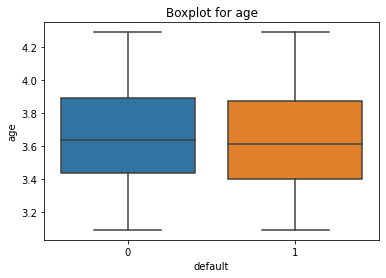

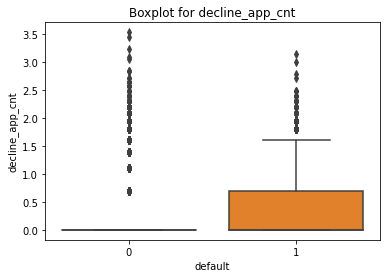

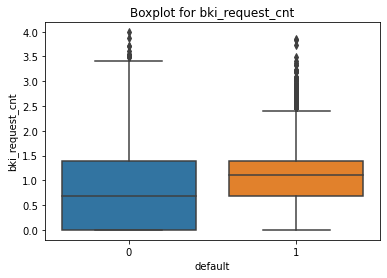

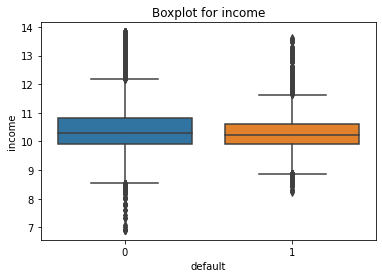

In [25]:
for i in num_cols:
    get_boxplot('default', i, data)

Во всех признаках, кроме возраста, много выбросов. Но убирать их не будем, потому что переменные могут принимать такие значения, и они могут быть важны для работы модели.

<AxesSubplot:>

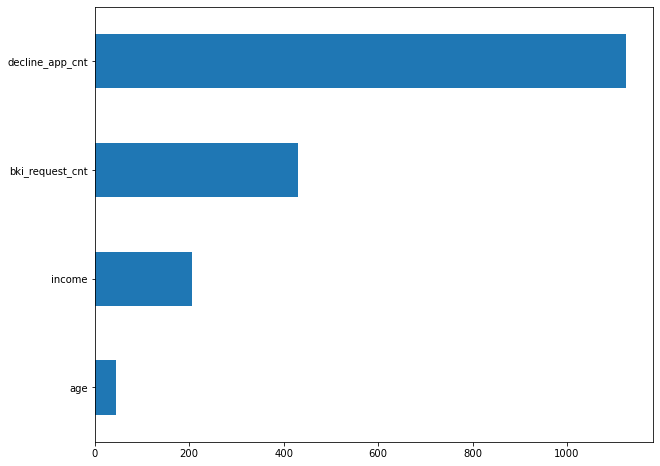

In [26]:
# Значимость непрерывных переменных
imp_num = Series(f_classif(data[num_cols], data['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Самые важные признаки: score_bki и decline_app_cnt. Самый мало значимый признак - age.

## Бинарные переменные

In [27]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

Нам нужно преобразовать в числа категории в колонках 'sex', 'car', 'car_type', 'foreign_passport'

In [28]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

## Категориальные переменные

In [29]:
# Необходимо заменить названия ступеней обучения на категории в признаке education
data['education'] = label_encoder.fit_transform(data['education'])

<AxesSubplot:>

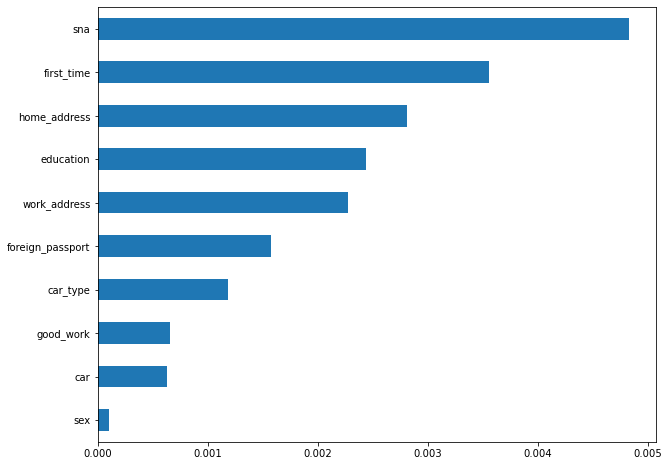

In [30]:
# Оценим значимость нечисловых переменных
imp_cat = Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Самые значимые признаки: sna, first_time, самый незначимый - sex

<AxesSubplot:>

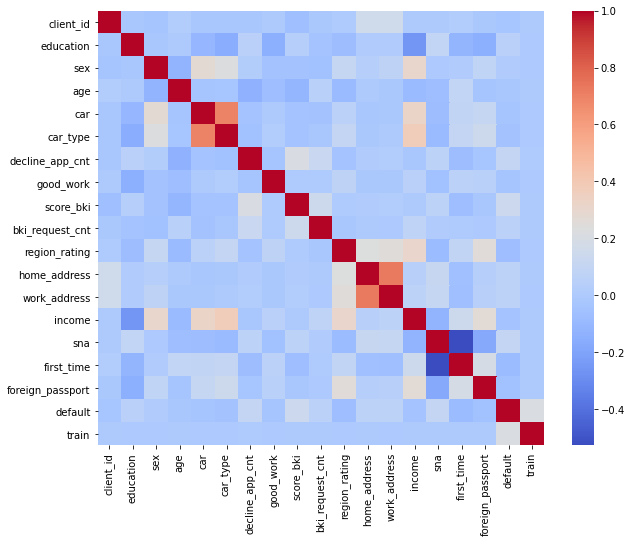

In [31]:
# Признаки обработали, посмотрим, что у нас в итоге получилось.
plt.rcParams['figure.figsize'] = (10, 8)
correlation = data.corr()
sns.heatmap(correlation, cmap='coolwarm')

Целевая переменная не имеет сильных линейных зависимостей с другими переменными. Есть сильные линейные зависимости между 'car' и 'car_type' и адресами.

# Генерация новых признаков

Видим, что есть зависимость между признаками 'car' и 'car_type', что ожидаемо. Сложим эти столбцы и сделаем из них один. Получится, что 0 - машины нет, 1 - есть отечественное авто, 2 - есть иномарка.

Также сделаем новый признак из адресов.

Создадим новый признак: порядковый номер дня с начала наблюдений.

In [32]:
data['new_car'] = data[['car', 'car_type']].sum(axis=1)
data.drop(['car', 'car_type'], axis=1, inplace=True)

""" by Safaroff. Считаю, эти признаки не нужно объединять
data['address'] = data[['work_address', 'home_address']].sum(axis=1)
data.drop(['work_address', 'home_address'], axis=1, inplace=True)
"""

data['day'] = (data.app_date - start).dt.days.astype('int')

# Уберем нечисловой признак app_date
data.drop(['app_date'], axis=1, inplace=True)

## Проверим корреляции 

<AxesSubplot:>

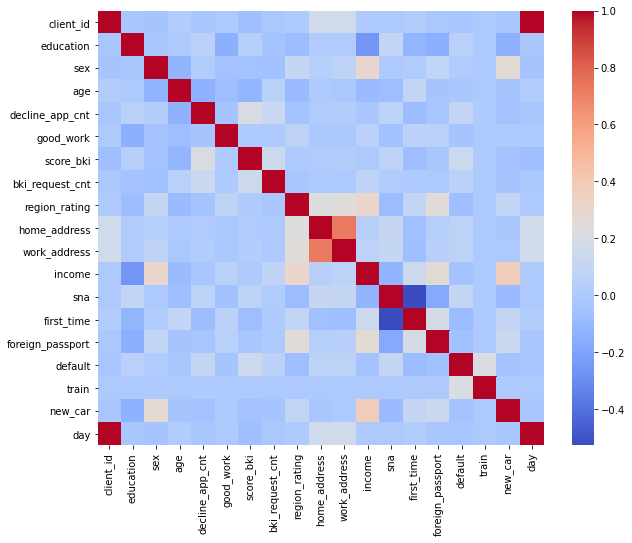

In [33]:
plt.rcParams['figure.figsize'] = (10, 8)
correlation = data.corr()
sns.heatmap(correlation, cmap='coolwarm')

Видим, что есть сильная корреляция между client_id и day, видимо, клиентам присваивали номер в порядке обращения

In [34]:
# Распределим переменные по типу
bin_cols = ['sex', 'foreign_passport', 'good_work']
cat_cols = ['education', 'new_car', 'work_address', 'home_address', 'sna', 'first_time', 'region_rating'] # 'address',
num_cols = ['age', 'decline_app_cnt', 'score_bki','bki_request_cnt', 'income', 'day']

# Построение модели

## Обучим модель и подберем гиперпараметры на обучающем датасете

In [35]:
# выделяем тренировочный датасет из датасета data
data_train = data[data['train'] == 1]
data_train = data_train.drop(['train'], axis=1)

# проверяем тренировочный датасет
display(data_train.head(5))

,client_id,education,sex,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,new_car,day
0,25905,3,1,4.143135,0.000000,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0,2,31
1,63161,3,0,4.094345,0.000000,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0,0,70
2,25887,3,1,3.258097,1.098612,0,-1.408142,0.693147,80,1,2,10.308986,1,4,1,0,1,31
3,16222,3,0,3.988984,0.000000,0,-2.057471,1.098612,50,2,3,9.210440,1,3,0,0,0,22
4,101655,1,1,3.891820,0.000000,1,-1.244723,0.693147,60,2,3,10.308986,1,4,1,0,0,107


In [36]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73799 entries, 0 to 73798
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   education         73799 non-null  int64  
 2   sex               73799 non-null  int64  
 3   age               73799 non-null  float64
 4   decline_app_cnt   73799 non-null  float64
 5   good_work         73799 non-null  int64  
 6   score_bki         73799 non-null  float64
 7   bki_request_cnt   73799 non-null  float64
 8   region_rating     73799 non-null  int64  
 9   home_address      73799 non-null  int64  
 10  work_address      73799 non-null  int64  
 11  income            73799 non-null  float64
 12  sna               73799 non-null  int64  
 13  first_time        73799 non-null  int64  
 14  foreign_passport  73799 non-null  int64  
 15  default           73799 non-null  int64  
 16  new_car           73799 non-null  int64 

In [37]:
# преобразуем категориальные переменные методом One-Hot Encoding
data_train_cat = OneHotEncoder(sparse=False).fit_transform(
    data_train[cat_cols].values)
data_train_cat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [38]:
# стандартизируем числовые переменные
data_train_num = StandardScaler().fit_transform(data_train[num_cols].values)

# объединяем категориальные, бинарные, числовые признаки в одно признаковое пространство
X = np.hstack([data_train_num, data_train[bin_cols].values, data_train_cat])
y = data_train['default'].values

In [39]:
# Разделим данные для обучения следующим образом:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

# Проверим
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((59039, 38), (14760, 38), (59039,), (14760,))

In [40]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

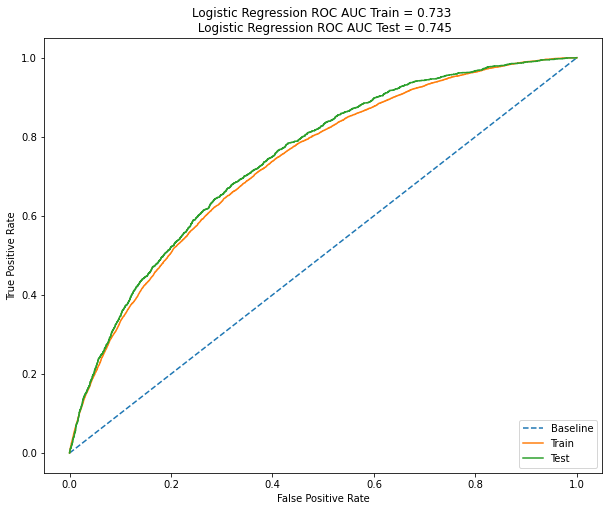

In [41]:
# считаем метрики обучающей (X_train, y_train) выборки
y_train_probs = model.predict_proba(X_train)
y_train_probs = y_train_probs[:, 1]
y_train_pred = model.predict(X_train)
fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_train_probs)
roc_auc_train = roc_auc_score(y_train, y_train_probs)

# считаем метрики тестовой (X_test, y_test) выборки
y_test_probs = model.predict_proba(X_test)
y_test_probs = y_test_probs[:, 1]
y_test_pred = model.predict(X_test)
fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_test_probs)
roc_auc_test = roc_auc_score(y_test, y_test_probs)

# строим графики ROC AUC
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr_train, tpr_train, label='Train')
plt.plot(fpr_test, tpr_test, label='Test')
plt.title('Logistic Regression ROC AUC Train = {a} \n Logistic Regression ROC AUC Test = {b}'
          .format(a=roc_auc_train.round(3), b=roc_auc_test.round(3)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [42]:
# Считаем метрики для обучающей и тестовой выборок
accuracy_train = accuracy_score(y_train, y_train_pred)
f1_score_train = f1_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)

accuracy_test = accuracy_score(y_test, y_test_pred)
f1_score_test = f1_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)

print('Accuracy:', round(accuracy_train, 3), round(accuracy_test, 3))
print('F1_score:', round(f1_score_train, 3), round(f1_score_test, 3))
print('Precision:', round(precision_train, 3), round(precision_test, 3))
print('Recall:', round(recall_train, 3), round(recall_test, 3))

Accuracy: 0.872 0.875
F1_score: 0.056 0.043
Precision: 0.483 0.402
Recall: 0.03 0.022


Confusion matrix, without normalization
[[12872    61]
 [ 1786    41]]
Normalized confusion matrix
[[0.99528338 0.00471662]
 [0.97755884 0.02244116]]


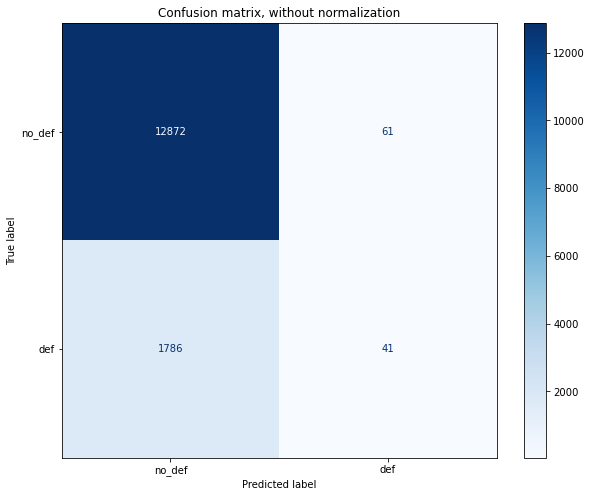

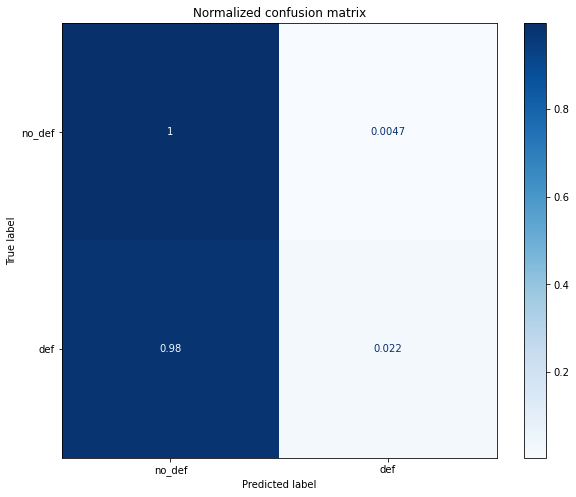

In [43]:
# Оценим confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=['no_def', 'def'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Как видно, несмотря на довольно хороший показатель ROC, модель очень плохо предсказывает дефолтных клиентов. Это очевидно из метрик f1-score, recall, а также confusion matrix.
Модель выдаст всем кредиты, их не вернут, банк разорен.

## Подбор гиперпараметров

In [44]:
model = LogisticRegression()
param_grid = [
    {'penalty': ['l1'],
     'solver': ['liblinear', 'lbfgs'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr']},
    {'penalty': ['l2'],
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr']},
    {'penalty': ['none'],
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr']}
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=10)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_

# печатаем параметры
best_parameters = model.get_params()
for param_name in best_parameters:
    print(param_name, best_parameters[param_name], '\n')

C 1.0 

class_weight balanced 

dual False 

fit_intercept True 

intercept_scaling 1 

l1_ratio None 

max_iter 100 

multi_class auto 

n_jobs None 

penalty none 

random_state None 

solver sag 

tol 0.0001 

verbose 0 

warm_start False 



## Обучение новой модели

In [45]:
# Разделим данные для обучения следующим образом:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

# Проверим
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((59039, 38), (14760, 38), (59039,), (14760,))

In [46]:
new_model = LogisticRegression(penalty='l1',
                               dual=False,
                               tol=0.0001,
                               C=1.0,
                               fit_intercept=True,
                               intercept_scaling=1,
                               class_weight='balanced',
                               random_state=None,
                               solver='liblinear',
                               max_iter=100,
                               multi_class='auto',
                               verbose=0,
                               warm_start=False,
                               n_jobs=None,
                               l1_ratio=None)
new_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear')

## Проверим качество новой модели

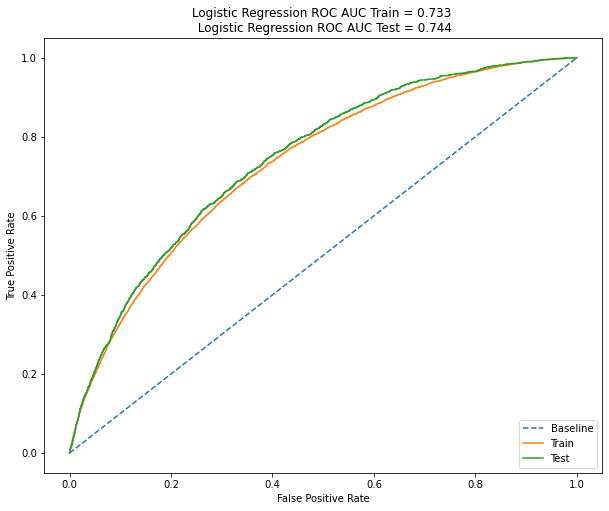

In [47]:
# считаем метрики обучающей (X_train, y_train) выборки
y_train_probs = new_model.predict_proba(X_train)
y_train_probs = y_train_probs[:, 1]
y_train_pred = new_model.predict(X_train)
fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_train_probs)
roc_auc_train = roc_auc_score(y_train, y_train_probs)

# считаем метрики тестовой (X_test, y_test) выборки
y_test_probs = new_model.predict_proba(X_test)
y_test_probs = y_test_probs[:, 1]
y_test_pred = new_model.predict(X_test)
fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_test_probs)
roc_auc_test = roc_auc_score(y_test, y_test_probs)

# строим графики ROC AUC
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr_train, tpr_train, label='Train')
plt.plot(fpr_test, tpr_test, label='Test')
plt.title('Logistic Regression ROC AUC Train = {a} \n Logistic Regression ROC AUC Test = {b}'
          .format(a=roc_auc_train.round(3), b=roc_auc_test.round(3)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [48]:
# Считаем метрики для обучающей и тестовой выборок
accuracy_train = accuracy_score(y_train, y_train_pred)
f1_score_train = f1_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)

accuracy_test = accuracy_score(y_test, y_test_pred)
f1_score_test = f1_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)

print('Accuracy:', round(accuracy_train, 3), round(accuracy_test, 3))
print('F1_score:', round(f1_score_train, 3), round(f1_score_test, 3))
print('Precision:', round(precision_train, 3), round(precision_test, 3))
print('Recall:', round(recall_train, 3), round(recall_test, 3))

Accuracy: 0.669 0.671
F1_score: 0.342 0.341
Precision: 0.229 0.227
Recall: 0.672 0.687


Confusion matrix, without normalization
[[8649 4284]
 [ 571 1256]]
Normalized confusion matrix
[[0.66875435 0.33124565]
 [0.31253421 0.68746579]]


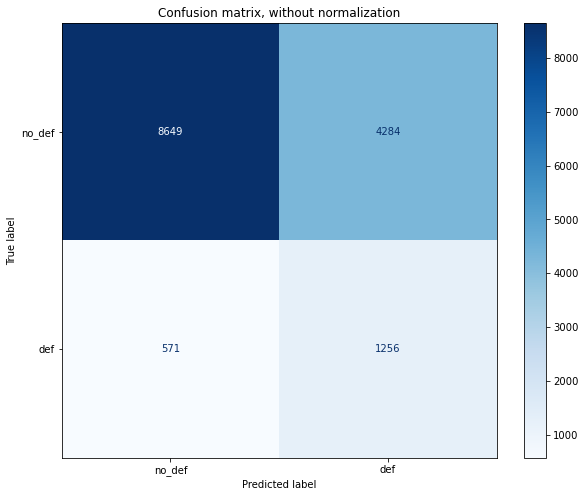

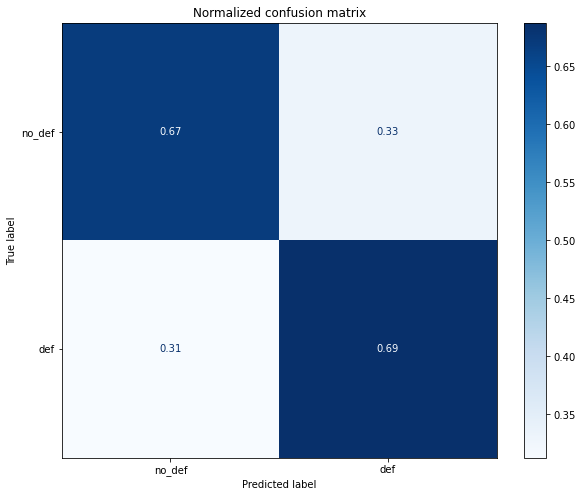

In [49]:
# Оценим confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(new_model, X_test, y_test,
                                 display_labels=['no_def', 'def'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Настройка модели не повлияла на метрику ROC-AUC, но существенно увеличила f1-score и recall. Значительно уменьшилось число дефолтных клиентов, которым модель была готова выдать кредит, и увеличилось число дефолтных клиентов, которые модель определила правильно. При этом выросло число клиентов, которым модель в кредите отказала, хотя они недефолтные.

В целом, модель стала более сбалансированной.

# Предсказание дефолтных клиентов

In [50]:
# выделяем тестовый датасет из датасета data
data_test = data[data['train'] == 0]
data_test = data_test.drop(['train'], axis=1)

In [51]:
data_test.head()

,client_id,education,sex,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,new_car,day
73799,74835,1,1,3.401197,0.000000,0,-2.271884,1.386294,50,1,2,10.819798,1,4,0,0,2,80
73800,17527,3,0,3.688879,1.791759,0,-1.504999,1.098612,50,1,2,8.517393,4,3,0,0,0,23
73801,75683,4,1,3.931826,0.000000,0,-1.691339,0.693147,50,1,2,10.308986,1,3,1,0,2,81
73802,26883,3,1,4.043051,0.000000,0,-2.374182,0.693147,40,1,2,9.741027,1,3,0,0,0,33
73803,28862,1,0,3.663562,0.000000,0,-2.487502,0.000000,80,2,3,11.695255,1,3,0,0,0,34


In [52]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36349 entries, 73799 to 110147
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   education         36349 non-null  int64  
 2   sex               36349 non-null  int64  
 3   age               36349 non-null  float64
 4   decline_app_cnt   36349 non-null  float64
 5   good_work         36349 non-null  int64  
 6   score_bki         36349 non-null  float64
 7   bki_request_cnt   36349 non-null  float64
 8   region_rating     36349 non-null  int64  
 9   home_address      36349 non-null  int64  
 10  work_address      36349 non-null  int64  
 11  income            36349 non-null  float64
 12  sna               36349 non-null  int64  
 13  first_time        36349 non-null  int64  
 14  foreign_passport  36349 non-null  int64  
 15  default           36349 non-null  int64  
 16  new_car           36349 non-null  i

In [53]:
# преобразуем категориальные переменные методом One-Hot Encoding
data_test_cat = OneHotEncoder(sparse=False).fit_transform(
    data_test[cat_cols].values)
data_test_cat

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [54]:
# стандартизируем числовые переменные
data_test_num = StandardScaler().fit_transform(data_test[num_cols].values)

# объединяем категориальные, бинарные, числовые признаки в одно признаковое пространство
X = np.hstack([data_test_num, data_test[bin_cols].values, data_test_cat])
y = data_test['default'].values

In [55]:
# делаем расчет
y = new_model.predict_proba(X)
y = y[:, 1]

In [56]:
# Создаем файл
submit = pd.DataFrame(data_test.client_id)
submit['default'] = y
submit.to_csv('submission.csv', index=False)

Выводы.

Значение метрики ROC AUC - 0.743.

При этом низкие значения метрик f1-score и precision указывают на то, что модель часто отказывает в выдаче кредита надежным клиентам.
